# Overview

This notebook provides support for an article at Medium.com.

Initial concepts over at [ComparisonGroupScratchSpace.ipynb](ComparisonGroupScratchSpace).

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy.spatial import distance
from scipy.stats import zscore

from pandas_profiling import ProfileReport
import seaborn as sns

# Get & Prepare Data

In [2]:
# Use data from US Department of Education IPEDS Surveys
# This data prepared by: https://github.com/adamrossnelson/StataIPEDSAll
location = r'~/documents/ipeds_data/'
dir_info = pd.read_stata(location + 'IPEDSDirInfo02to18.dta')
inst_chs = pd.read_stata(location + 'IPEDSInstChar02to18.dta')

In [3]:
dir_info_17 = dir_info[dir_info['isYr'] == 2017].copy()
inst_chs_17 = inst_chs[inst_chs['isYr'] == 2017].copy()

del dir_info_17['isYr']
del inst_chs_17['isYr']

In [4]:
df = pd.merge(dir_info_17, inst_chs_17, on='unitid')

In [5]:
# Keep a subset of variables only.
# Original dictionary files: 
#   https://nces.ed.gov/ipeds/datacenter/data/HD2017_Dict.zip
#   https://nces.ed.gov/ipeds/datacenter/data/IC2017_Dict.zip
# 
#  unitid   : Unique identificaiotn number.
#  instnm   : Institution name.
#  stabbr   : Institution state abbreviation.
#  sector   : Sector (public, private, 2yr, 4yr, etc.)
#  iclevel  : Two-years, four-yeasr, etc.
#  control  : Public or private institution status.
#  locale   : Urbanicity index.
#  instcat  : Degree-granting category.
#  c18basic : Carnegie classification.
#  instsize : Categorical institution size.
#  longitud : Geographic longidue location.
#  latitude : Geographic latitude location.
#  roomcap  : Residence hall room capacity.
#  roomamt  : Residence hall room fees.
#  boardamt : Dining hall fees.
#  applfeeu : Application fees.
#  applcn   : Count of undergraduate applications.
#  admssn   : Count of undergraduate admissions.
#  enrlft   : Count of full-time enrollment.
#  enrlt    : Count of enrollment.

df = df[['unitid','instnm','stabbr','sector','iclevel',
         'control','locale','instcat','c15basic','instsize',
         'longitud','latitude','roomcap','roomamt','boardamt',
         'rmbrdamt','applfeeu','applcn','admssn','enrlft',
         'enrlt']]

# Define a selectivity index as number of admissions over
# the number of applications. Admission rate.
df['accept'] = df['admssn'] / df['applcn']

# Setting the unitid as the data frame index.
df.set_index('unitid', inplace=True)

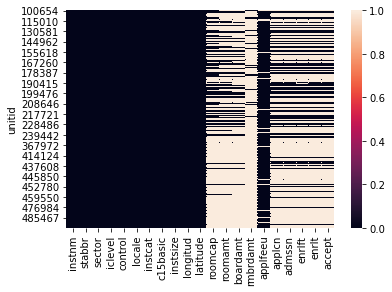

In [6]:
sns.heatmap(df.isna())

In [7]:
# Limit the analysis to public & private 4 year institutions
df = df[(df['sector'] == 'Public, 4-year or above') | \
        (df['sector'] == 'Private not-for-profit, 4-year or above')]
# Limit the analysis to schools with a residence hall capacity.
df = df[df['roomcap'].fillna(-9999) != -9999]
# Limit the analysis to schools that report application data.
df = df[df['applcn'].fillna(-9999) != -9999]

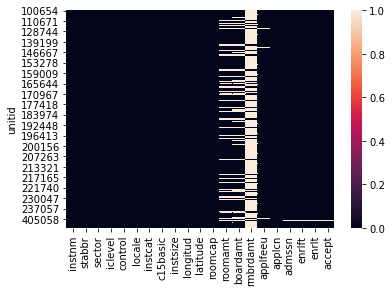

In [8]:
sns.heatmap(df.isna())

In [9]:
df[['roomamt','boardamt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
roomamt,1238.0,6082.14378,2171.780094,0.0,4600.0,5900.0,7354.5,16675.0
boardamt,1170.0,4597.68547,1193.423839,0.0,3830.0,4581.5,5340.0,8965.0


In [10]:
# Some institutions (n=431) will report combined room & board.
# Estimate room amount as 60% of combined amount.
# Estimate board amount as 40% of combined amount.
df['roomamtX'] = [y * .6 if x == -99 else x for x, y in \
                  zip(df['roomamt'].fillna(-99), df['rmbrdamt'])]
df['boardamtX'] = [y * .4 if x == -99 else x for x, y in \
                   zip(df['boardamt'].fillna(-99), df['rmbrdamt'])]
# Replace missing application fee as zero? Free to apply?
df['applfeeu'].fillna(0, inplace=True)

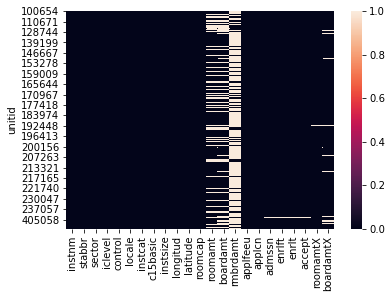

In [11]:
sns.heatmap(df.isna())

In [12]:
df[df['boardamtX'].fillna(-9999) == -9999][['instnm','sector','admssn','rmbrdamt',
                                            'roomamt','roomamtX','boardamt','boardamtX']]

,instnm,sector,admssn,rmbrdamt,roomamt,roomamtX,boardamt,boardamtX
unitid,,,,,,,,
110370,California College of the Arts,"Private not-for-profit, 4-year or above",1277.0,NaN,9840.0,9840.0,NaN,NaN
110547,California State University-Dominguez Hills,"Public, 4-year or above",9333.0,NaN,9012.0,9012.0,NaN,NaN
110918,California Christian College,"Private not-for-profit, 4-year or above",3.0,NaN,4950.0,4950.0,NaN,NaN
117168,Laguna College of Art and Design,"Private not-for-profit, 4-year or above",259.0,NaN,9700.0,9700.0,NaN,NaN
123280,Shasta Bible College and Graduate School,"Private not-for-profit, 4-year or above",7.0,NaN,2400.0,2400.0,NaN,NaN
...,...,...,...,...,...,...,...,...
462354,John Paul the Great Catholic University,"Private not-for-profit, 4-year or above",191.0,NaN,7650.0,7650.0,NaN,NaN
484844,Minerva Schools at Keck Graduate Institute,"Private not-for-profit, 4-year or above",382.0,NaN,10000.0,10000.0,NaN,NaN
486053,Bethlehem College & Seminary,"Private not-for-profit, 4-year or above",27.0,NaN,3400.0,3400.0,NaN,NaN


In [13]:
# 70 Institutions report a room amount but no board amount.
# Change room amount to 60% of reported roomamt.
df['roomamtX'].fillna(df['roomamt'] * .6, inplace=True)
# Enter board amount as 40% of room amount
df['boardamtX'].fillna(df['roomamt'] * .4, inplace=True)

In [14]:
# Check results, display remaining obs with missing data.
df[df['boardamtX'].fillna(-9999) == -9999][['instnm','sector','admssn','rmbrdamt',
                                            'roomamt','roomamtX','boardamt','boardamtX']]

,instnm,sector,admssn,rmbrdamt,roomamt,roomamtX,boardamt,boardamtX
unitid,,,,,,,,
149329,Telshe Yeshiva-Chicago,"Private not-for-profit, 4-year or above",19.0,NaN,NaN,NaN,NaN,NaN
192624,Machzikei Hadath Rabbinical College,"Private not-for-profit, 4-year or above",54.0,NaN,NaN,NaN,NaN,NaN


In [15]:
# Display remaining observations with missing admission fee information
df[df['admssn'].fillna(-9999) == -9999][['instnm','applfeeu','admssn',
                                         'enrlft','enrlt','accept']]

,instnm,applfeeu,admssn,enrlft,enrlt,accept
unitid,,,,,,
142957,American Islamic College,25.0,NaN,NaN,NaN,NaN
245777,Bais Medrash Elyon,0.0,NaN,NaN,NaN,NaN
441609,Yeshiva Shaarei Torah of Rockland,100.0,NaN,NaN,NaN,NaN


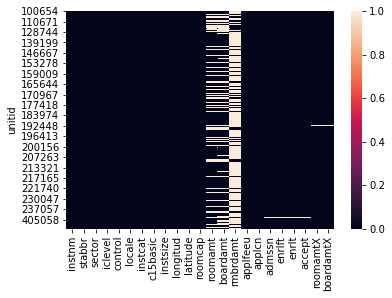

In [16]:
sns.heatmap(df.isna())

In [17]:
# Drop original columns
del df['roomamt']
del df['boardamt']
del df['rmbrdamt']
# Drop these five observations.
df.dropna(inplace=True)

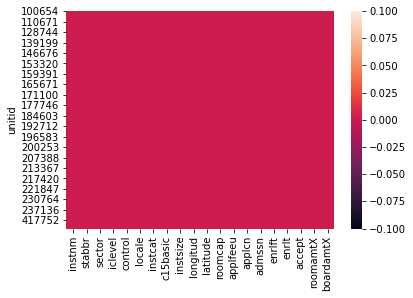

In [18]:
sns.heatmap(df.isna())

In [20]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [21]:
profile.to_file("ipeds_data_sample_2017_report.html")

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Define Functions

In [22]:
def jaccard(data, ref, cols, verbose=False):
    '''Calculates Jarcard index for all observations
    relative to the referenced observation. Returns a list
    of Jaccardian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    try:
        ref_observation = data[cols].iloc[ref]
    except IndexError:
        ref_observation = data[cols].loc[ref]
        ref = df.index.get_loc(ref)
    
    distances = []
    length = len(cols) 
        
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(ref_observation,
                                                          comp_observation)])
        distances.append(1 - (matches / length))
    
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
        
    return(distances)

# Goal: Count the number of matching dimensions among two observations
def hamming(data, ref, cols):
    '''Calculates Hamming distance for all observations
    relative to the referenced observation. Returns a list
    of hamming distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    if type(ref) == int:
        ref = ref
    if type(ref) == str:
        ref = df.index.get_loc(ref)

    distances = []
    ref_observation = data[cols].iloc[ref]
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(comp_observation,
                                                          ref_observation)])
        distances.append(matches)
    return(distances)

def euclidian(data, ref, cols, verbose=False):
    '''Calculates Euclidian distance for all observations
    relative to the referenced observation. Returns a list
    of euclidian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''
        
    try:
        ref_observation = data[cols].apply(zscore).iloc[ref]
    except IndexError:
        ref_observation = data[cols].apply(zscore).loc[ref] 
        ref = df.index.get_loc(ref)
    
    distances = []
    for row in range(len(data)):
        comp_observation = data[cols].apply(zscore).iloc[row]
        dist = distance.euclidean(ref_observation, comp_observation)
        distances.append(dist)
        
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
    
    return(distances)

# Case Sudies

## University of Wisconsin-Madison

### Euclidian

In [23]:
# Review Madison's profile based on this data.
df.loc[240444]

instnm                         University of Wisconsin-Madison
stabbr                                                      WI
sector                                 Public, 4-year or above
iclevel                                     Four or more years
control                                                 Public
locale                                             City: Large
instcat      Degree-granting, primarily baccalaureate or above
c15basic      Doctoral Universities: Highest Research Activity
instsize                                      20,000 and above
longitud                                              -89.4041
latitude                                               43.0754
roomcap                                                   8644
applfeeu                                                    60
applcn                                                   35596
admssn                                                   19153
enrlft                                                 

In [25]:
continous_cols = ['longitud','latitude','roomcap','roomamtX','boardamtX',
                  'applfeeu','accept','enrlft']
df['WI_euclidian'] = euclidian(data=df, ref=240444, 
                               cols=continous_cols,
                               verbose=True)

Returning 1539 distances.
Minimum distance = 0 : True
Maximum distance = 17.351702131545423
Mean distance = 5.99540613087614


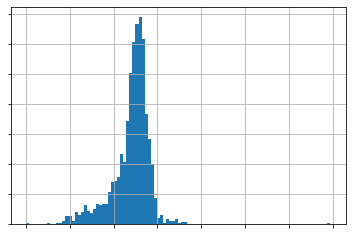

In [27]:
df['WI_euclidian'].hist(bins=100)

In [28]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[240444]['WI_euclidian'] == 0)
print(df.loc[240444]['WI_euclidian'])

True
0.0


In [29]:
df.sort_values(by='WI_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['WI_euclidian']].head(n=10)

,instnm,stabbr,longitud,latitude,roomcap,roomamtX,boardamtX,applfeeu,accept,enrlft,WI_euclidian
unitid,,,,,,,,,,,
240444,University of Wisconsin-Madison,WI,-89.404099,43.075409,8644.0,6225.0,3125.0,60.0,0.538066,6597.0,0.000000
174066,University of Minnesota-Twin Cities,MN,-93.235466,44.972851,7294.0,5586.0,4266.0,55.0,0.496033,6183.0,1.254827
233921,Virginia Polytechnic Institute and State Unive...,VA,-80.423676,37.229012,9459.0,5212.0,3988.0,60.0,0.700580,6832.0,1.780604
181464,University of Nebraska-Lincoln,NE,-96.700508,40.817596,7200.0,6594.0,4450.0,45.0,0.643808,4883.0,2.027057
216339,Temple University,PA,-75.156860,39.980545,6003.0,7752.0,3944.0,55.0,0.566695,5141.0,2.149792
139959,University of Georgia,GA,-83.374039,33.956261,9727.0,6104.0,3956.0,70.0,0.540120,5809.0,2.171649
201885,University of Cincinnati-Main Campus,OH,-84.514282,39.131161,6690.0,6624.0,4494.0,50.0,0.764924,5358.0,2.188124
218663,University of South Carolina-Columbia,SC,-81.026932,33.996788,8235.0,6280.0,3728.0,65.0,0.723083,5838.0,2.257969
100751,The University of Alabama,AL,-87.545975,33.211876,8449.0,5750.0,3674.0,40.0,0.532954,7385.0,2.288884


### Jacardian

In [ ]:
# Define a selectivity index as quitile of accept.
df['selectivity'] = pd.qcut(df['accept'], q=4, labels=['higest selectivity','high selectivity',
                                                       'moderate selectivity','lowest selectivity'])

In [32]:
# Review Madison's profile based on this data.
df.loc[240444]

instnm                            University of Wisconsin-Madison
stabbr                                                         WI
sector                                    Public, 4-year or above
iclevel                                        Four or more years
control                                                    Public
locale                                                City: Large
instcat         Degree-granting, primarily baccalaureate or above
c15basic         Doctoral Universities: Highest Research Activity
instsize                                         20,000 and above
longitud                                                 -89.4041
latitude                                                  43.0754
roomcap                                                      8644
applfeeu                                                       60
applcn                                                      35596
admssn                                                      19153
enrlft    

In [33]:
cat_cols = ['stabbr','iclevel','control','locale',
            'c15basic','instsize','selectivity']
df['WI_jacardian'] = jaccard(data=df, ref=240444, 
                             cols=cat_cols,
                             verbose=True)

Returning 1539 distances.
Minimum distance = 0 : True
Maximum distance = 0.8571428571428572
Mean distance = 0.7151211361737674


In [38]:
df.sort_values(by=['WI_jacardian','WI_euclidian'], inplace=True)
df[['instnm'] + cat_cols + \
   ['WI_euclidian','WI_jacardian']].head(n=15)

,instnm,stabbr,iclevel,control,locale,c15basic,instsize,selectivity,WI_euclidian,WI_jacardian
unitid,,,,,,,,,,
240444,University of Wisconsin-Madison,WI,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,0.000000,0.000000
174066,University of Minnesota-Twin Cities,MN,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,1.254827,0.142857
199193,North Carolina State University at Raleigh,NC,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,2.546534,0.142857
236948,University of Washington-Seattle Campus,WA,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,2.735421,0.142857
228778,The University of Texas at Austin,TX,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,3.186707,0.142857
204796,Ohio State University-Main Campus,OH,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,3.298439,0.142857
240453,University of Wisconsin-Milwaukee,WI,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",moderate selectivity,3.403969,0.142857
139755,Georgia Institute of Technology-Main Campus,GA,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,4.012572,0.142857
110680,University of California-San Diego,CA,Four or more years,Public,City: Large,Doctoral Universities: Highest Research Activity,"20,000 and above",higest selectivity,4.083317,0.142857


## University of North Carolina Charlotte

In [ ]:
df.loc[199139]

In [ ]:
continous_cols = ['longitud','latitude','roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

In [ ]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[199139]['CLT_euclidian'] == 0)
print(df.loc[199139]['CLT_euclidian'])

In [ ]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)

In [ ]:
continous_cols = ['roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

In [ ]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)